In [1]:
import numpy as np
import os

# Mixed sounds

Several architectures can be comparated using random optimization

In [24]:
from nideep.eval.eval_utils import Phase
from nideep.eval.learning_curve import LearningCurve

metric_names = ['min_train_loss', \
                'min_test_loss', \
                'mean_train_loss', \
                'mean_test_loss', \
                'test_train_diff']

def name_folder(batch):
    return '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/mix_essai/' + batch

def name_metric(metric, task):
    return metric + '_' + task

def summary(log, tasks, metric_names):
    """Important metrics on log"""
    s = {}
    e = LearningCurve(log)
    e.parse()
    
    for task in tasks:
        train_num = e.list('NumIters', Phase.TRAIN)
        test_num = e.list('NumIters', Phase.TEST)
        train_loss = e.list(name_metric('loss', task), Phase.TRAIN)
        train_loss_ = np.array([train_loss[np.abs(train_num - i[0]).argmin()] for i in test_num]) # adjusted to test phase
        test_loss = e.list(name_metric('loss', task), Phase.TEST)
        plateau = int(len(test_num) * .25) + 1 # last 25% of test phase

        min_train_loss = np.min(train_loss)
        min_test_loss = np.min(test_loss)
        mean_train_loss = np.mean(train_loss[-plateau:])
        mean_test_loss = np.mean(test_loss[-plateau:])
        test_train_diff = np.min(np.absolute(train_loss_ - test_loss) / np.maximum(train_loss_, test_loss))
        
        s[task] = {}
        for metric_name in metric_names:
            s[task][metric_name] = eval(metric_name)

    return s

def summaries(logs, tasks, metric_names, print_=True):
    """Aggregate all summaries from logs"""
    # dic initialization
    ss = {}
    for task in tasks:
        ss[task] = {}
        for metric_name in metric_names:
            ss[task][metric_name] = []
    # fill the dic with summary reports from all logs
    for log in logs:
        #if print_: print "  >", log.split("/")[-1] # UNCOMMENT TO DEBUG
        s = summary(log, tasks, metric_names)
        for task in tasks:
            for metric_name in metric_names:
                ss[task][metric_name].append(s[task][metric_name])
    return ss

def name_logs(batch, numbers):
    """Produce paths to logs for repository 'batch' and specified numbers"""
    return [name_folder(batch) + '/logs/caffe' + str(i) for i in numbers]

logs = name_logs('amsildrmp_oneconvtwoip_concat_TOLAUNCH', [0, 1])
tasks = ['id_loc']

#summary(logs[0], tasks, metric_names)
#summaries(logs, tasks, metric_names)

In [25]:
def get_good_logs(batch, task='id_loc', threshold_inf=0, threshold_max=25, print_=True):
    """Lists all logs with valid networks"""
    logs = name_logs(batch, range(100))
    good_logs = []
    for log in logs:
        #if print_: print "  >", log.split("/")[-1] # UNCOMMENT TO DEBUG
        if os.path.isfile(log):
            e = LearningCurve(log)
            e.parse()
            train_loss = e.list(name_metric('loss', task), Phase.TRAIN)
            test_loss = e.list(name_metric('loss', task), Phase.TEST)
            test_num = e.list('NumIters', Phase.TEST)
            plateau = int(len(test_num) * .25) + 1 # last 25% of test phase
            mean_test_loss = np.mean(test_loss[-plateau:])
            try:
                if len(test_num) <> 0 and len(train_loss) <> 0 and mean_test_loss < 12 and np.min(test_loss) < 10 and np.min(train_loss) >= threshold_inf and np.min(train_loss) <= threshold_max:
                    good_logs.append(log)
            except:
                pass
    if print_:
        print "For", batch, len(good_logs), "valid logs were found"
    return good_logs

In [30]:
names = ['ild_1\nconv2ip',
         #'rmp_1conv\n2ip',
         'all_1conv\n2ip_10x10',
         'all_1conv\n2ip_12x16',
         'all_1conv\n2ip_16x16',
         'all_2conv\n2ip_16x16',
         'all_3conv\n2ip_16x16']

In [31]:
logs = []
s = {}
batches = ['ild_oneconvtwoip',
           #'rmp_oneconvtwoip',
           'amsildrmp_oneconvtwoip_concat10x10',
           'amsildrmp_oneconvtwoip_concat12x16_TOLAUNCH',
           'amsildrmp_oneconvtwoip_concat16x16_TOLAUNCH',
           'amsildrmp_twoconvtwoip_concat16x16_TOLAUNCH',
           'amsildrmp_threeconvtwoip_concat16x16_TOLAUNCH']
for batch in batches:
    s[batch] = {}
    s[batch]['logs'] = get_good_logs(batch, task='id_loc', threshold_inf=0, threshold_max=20)
    s[batch]['summary'] = summaries(s[batch]['logs'], tasks, metric_names)

For ild_oneconvtwoip 8 valid logs were found
For amsildrmp_oneconvtwoip_concat10x10 42 valid logs were found
For amsildrmp_oneconvtwoip_concat12x16_TOLAUNCH 5 valid logs were found
For amsildrmp_oneconvtwoip_concat16x16_TOLAUNCH 28 valid logs were found
For amsildrmp_twoconvtwoip_concat16x16_TOLAUNCH 28 valid logs were found
For amsildrmp_threeconvtwoip_concat16x16_TOLAUNCH 36 valid logs were found


min_train_loss


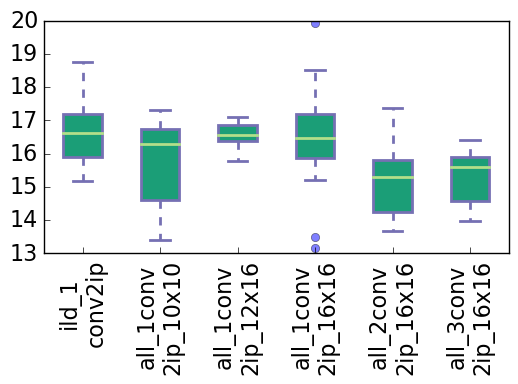

min_test_loss


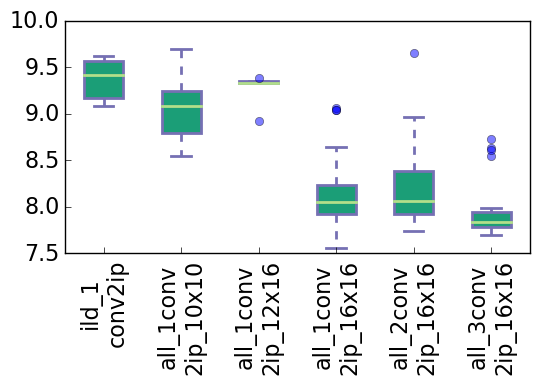

mean_train_loss


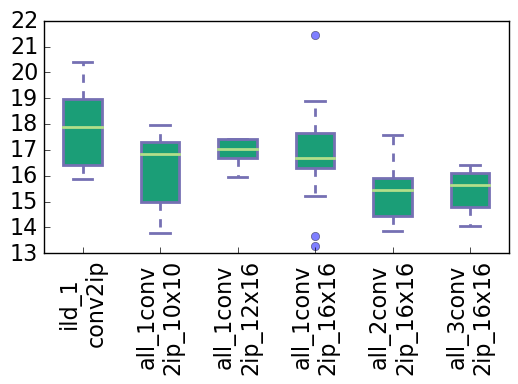

mean_test_loss


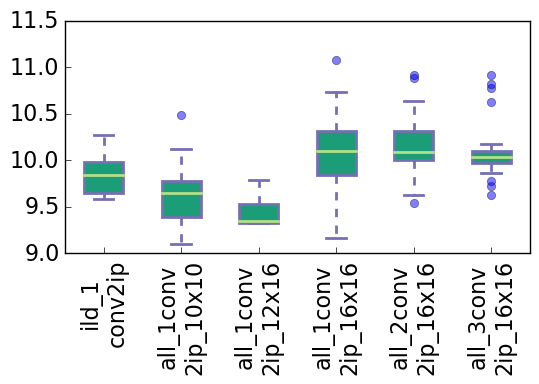

test_train_diff


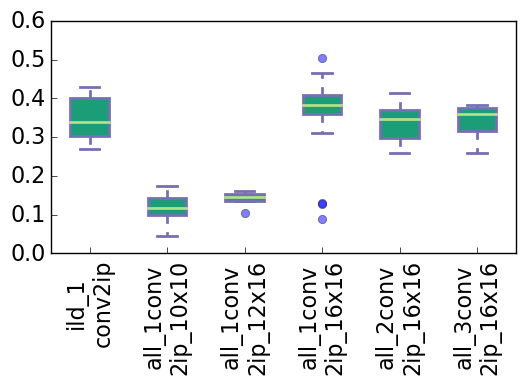

In [32]:
import matplotlib.pyplot as plt 
import matplotlib
from matplotlib import rc
matplotlib.rcParams.update({'font.size': 16, 'text.usetex': False})
#matplotlib.rcParams['text.usetex']=True
#matplotlib.rcParams['text.latex.unicode']=True
#rc('font',**{'size':22,'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)

task = 'id_loc'

for metric_name in metric_names:
    print metric_name
    # Boxplots
    fig = plt.figure(1, figsize=(6, 3))
    ax = fig.add_subplot(111)
    toplot = [s[batch]['summary'][task][metric_name] for batch in batches]
    bp = ax.boxplot(toplot, patch_artist=True)
    # Layout
    for box in bp['boxes']:
        box.set(color='#7570b3', linewidth=2)
        box.set(facecolor = '#1b9e77')
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    # Legend
    ax.set_xticklabels(names, rotation='vertical')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.savefig(name_folder(metric_name))
    plt.show()

In [7]:
for task in tasks:
    print task
    for batch in batches:
        print "   -", batch
        losses = s[batch]['summary'][task]['min_test_loss']
        logs = s[batch]['logs']
        best_losses, best_logs = (list(t) for t in zip(*sorted(zip(losses, logs), reverse=False)))

        print "       ", "> Best test loss:", best_losses[0]
        print "       ", "> Best net architecture:", best_logs[0].split("/")[-1]
        print ""

id_loc
   - ild_oneconvtwoip
        > Best test loss: 9.08407
        > Best net architecture: caffe34

   - rmp_oneconvtwoip
        > Best test loss: 12.8004
        > Best net architecture: caffe38

   - amsildrmp_oneconvtwoip_concat10x10
        > Best test loss: 8.54504
        > Best net architecture: caffe35

   - amsildrmp_oneconvtwoip_concat12x16_TOLAUNCH
        > Best test loss: 8.91889
        > Best net architecture: caffe1

   - amsildrmp_oneconvtwoip_concat16x16_TOLAUNCH
        > Best test loss: 7.55745
        > Best net architecture: caffe43

   - amsildrmp_twoconvtwoip_concat16x16_TOLAUNCH
        > Best test loss: 7.74208
        > Best net architecture: caffe0

   - amsildrmp_threeconvtwoip_concat16x16_TOLAUNCH
        > Best test loss: 7.69551
        > Best net architecture: caffe27

